# Exact Diagonalization of a 1D Spin Chain
<b> Christina Lee

Category: Grad

Prerequisites: Many-Body Quantum Mechanics, Part 1 </b>

Check out part 1 for the theory background.  Today is all programming.

Here we will initialize how many spins we will have in our chain.  

Remember to keep a reasonable number.  

Your number of states goes as $2^n$, and the size of your Hamiltonian will goes as $4^n$.  A 10-spin chain will already have over a million entries, before taking into account our tricks.

On my machine that has 16Gb of RAM and 3.2 GHz Intel i5 processor:

| n | m_z | t (min) | Memory (Gb) |
|---|-----|---------|-------------|
|16 | 8   | 1.5     | 2           |
|18 | 9   | ?       |  >16        |
|18 | 8   | 32.1    |   15.5      |

I included a file in this directory, ED.jl, that is the functional, rather than demonstrative, version of the code here.  For running large $n$, I recommend using that.  

Here went enter one parameter `n`, the number of spins in our chain.

The parameter `nstates` is automatically calculated given `n`.


In [2]:
n=4
nstates=2^n

16

First. let's write out all our possible states in the $S^z$ basis.

In [3]:
psi=collect(0:(nstates-1))
for p in psi
    println(bin(p,n),' ',p)
end

0000 0
0001 1
0010 2
0011 3
0100 4
0101 5
0110 6
0111 7
1000 8
1001 9
1010 10
1011 11
1100 12
1101 13
1110 14
1111 15


As in Part 1, we will be using the powers of 2 and the masks I described to perform operations on numbers.  So we don't have to calculate them each time, we just store them in memory.

In [5]:
powers2=collect(0:(n-1));
powers2=2.^powers2;

mask=[0;powers2]+[powers2;0];
mask=[mask[2:end-1];[1+2^(n-1)]]
for m in mask
    println(bin(m,n))
end

0011
0110
1100
1001


`m` will be an array that will store the magnetization of each state.   See Part 1 for more explanation of how this works.  

In Part 1, I just talked about counting the number of up-spins as magnetization.   That's not true.  An up-spin is $+1/2$ and a down-spin is $-1/2$.  So we have to just modify our magnetization a little.

In [6]:
m=zeros(psi)
for i in 1:nstates
    m[i]=sum((psi[i]&powers2)./(powers2))
end
m=(m-n/2)/2

16-element Array{Float64,1}:
 -1.0
 -0.5
 -0.5
  0.0
 -0.5
  0.0
  0.0
  0.5
 -0.5
  0.0
  0.0
  0.5
  0.0
  0.5
  0.5
  1.0

# Grouped by Magnetization

Now that we have the magnetizations corresponding to each state, we perform the trickery that allows us to dramatically reduce the difficulty of our problem. 

Magnetization is a conserved quantity, so we know that the Hamiltonian is not going to mix states of different magnetizations.   So we only have to deal with one magnetization at a time, which is a much smaller problem.  

First, we are going to sort our states by magnetization.

In [7]:
ind=sortperm(m)
m=m[ind]
psi=psi[ind]
[psi m]

16×2 Array{Float64,2}:
  0.0  -1.0
  1.0  -0.5
  2.0  -0.5
  4.0  -0.5
  8.0  -0.5
  3.0   0.0
  5.0   0.0
  6.0   0.0
  9.0   0.0
 10.0   0.0
 12.0   0.0
  7.0   0.5
 11.0   0.5
 13.0   0.5
 14.0   0.5
 15.0   1.0

But even though they're now sorted, they're still mashed all together.  Now we want to pull them apart.

That's why we're are going to create an <b>Array of Arrays</b>.  Each elememt in `psia` will store all the states of a given magnetization.  

Why don't we just create a two dimensional array?

Because each element has a different length.  

The number of states at a given magnetization is given by a 

In [8]:
ma=collect(0:.5:n/2.)-n/4
    
psia=Array{Array{Int64}}(n+1)
first=1
last=1
for i in 1:(n+1)
    psia[i]=psi[first:last]
    
    #now we compute them for the next round
    first=last+1
    last=last+binomial(n,i)
end
psia

5-element Array{Array{Int64,N},1}:
 [0]            
 [1,2,4,8]      
 [3,5,6,9,10,12]
 [7,11,13,14]   
 [15]           

In [12]:
mz=3

dim=binomial(n,mz-1)

#M=ma[i]*(ma[i]+1)*eye(Float64,dim,dim)
M=zeros(Float64,dim,dim);

In [13]:
Psi=psia[mz]
for p in Psi
    println(bin(p,n),' ',p)
end

0011 3
0101 5
0110 6
1001 9
1010 10
1100 12


In [16]:
mp=sum(Psi[1]&powers2./powers2)

for ii in 1:length(Psi)
    p=Psi[ii]
    for jj in 1:n
        flipped=p$mask[jj]
        if sum((flipped&powers2)./powers2) == mp
            index=findstate(flipped,Psi)
            M[ii,index]=.5
            M[index,ii]=.5
            println(bin(p,n),'\t',bin(flipped,n))
        end
            
    end
end

0011	0101
0011	1010
0101	0110
0101	0011
0101	1001
0101	1100
0110	0101
0110	1010
1001	1010
1001	0101
1010	1001
1010	1100
1010	0110
1010	0011
1100	1010
1100	0101


In [17]:
M

6×6 Array{Float64,2}:
 0.0  0.5  0.0  0.0  0.5  0.0
 0.5  0.0  0.5  0.5  0.0  0.5
 0.0  0.5  0.0  0.0  0.5  0.0
 0.0  0.5  0.0  0.0  0.5  0.0
 0.5  0.0  0.5  0.5  0.0  0.5
 0.0  0.5  0.0  0.0  0.5  0.0

In [18]:
eig=eigvals(M)

6-element Array{Float64,1}:
 -1.41421    
 -8.67362e-17
  0.0        
  0.0        
  0.0        
  1.41421    

In [15]:
function findstate(state::Int,set::Array{Int})
    iimin=1
    iimax=length(set)
    
    if set[iimin] == state
        return iimin
    end
    if set[iimax] == state
        return iimax
    end
    
    
    found=false
    count=0
    
    while found==false && count < length(set)
        count+=1
        index=floor(Int,iimin+(iimax-iimin)/2)
        if state < set[index]
            iimax=index-1
        elseif state > set[index]
            iimin=index+1
        else
            found=true
            return index
        end
    end
    
    if found == false
        println("findstate never found a match")
        println("Are you sure the state is in that Array?")
    end
    
    return 0
end

findstate (generic function with 1 method)

In [19]:
v=eigvecs(M)

6×6 Array{Float64,2}:
  0.353553   0.0       -0.211325   0.788675  -0.288675    -0.353553
 -0.5        0.707107   0.0        0.0       -5.1279e-16  -0.5     
  0.353553   0.0        0.788675  -0.211325  -0.288675    -0.353553
  0.353553   0.0       -0.57735   -0.57735   -0.288675    -0.353553
 -0.5       -0.707107   0.0        0.0       -5.1279e-16  -0.5     
  0.353553   0.0        0.0        0.0        0.866025    -0.353553

In [68]:
temp=v[:,1]

for ii in 1:length(temp)
    if temp[((0:(length(temp)-1))+ii)%length(temp)+1]==temp
        println(ii)
    end
end

5


In [178]:
eigall=sort(eigall);

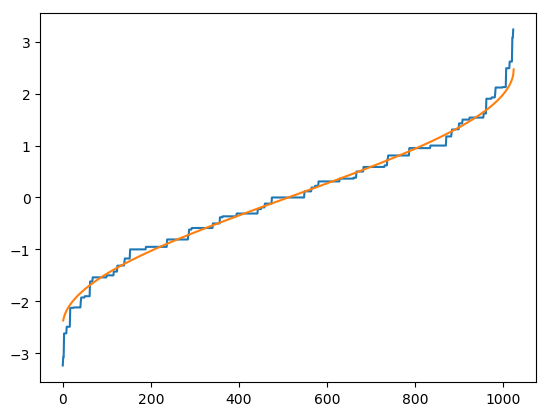

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000001EFFA630>

In [179]:
plot(eigall)
xtemp=collect(1:length(eigall))
ytemp=(-acos(xtemp*2/length(eigall)-1)+pi/2)*pi/2
plot(xtemp,ytemp)

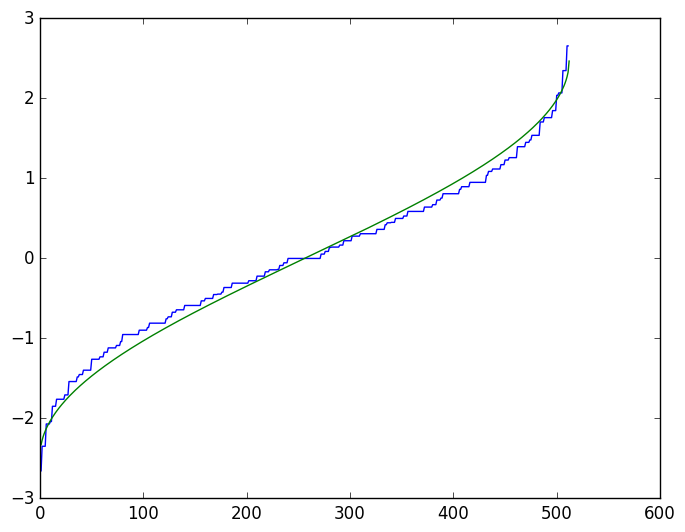

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fde0c43ac50>

In [99]:
plot(lambda)
xtemp=collect(1:length(lambda))
ytemp=(-acos(xtemp*2/length(lambda)-1)+pi/2)*pi/2
plot(xtemp,ytemp)